In [109]:
import re
import numpy as np
import pandas as pd
from collections import Counter
import plotly.express as px
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")

In [21]:
def startsWithDateAndTime(s):
    # regex pattern for date.
    pattern = "^\[([0-9]+)(\/)([0-9]+)(\/)([0-9][0-9]), ([0-9]+):([0-9][0-9]):([0-9][0-9]) (a|p).m.\] .*"
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [22]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe

chat = 'chat.txt' # chat file

with open(chat, encoding="utf-8") as file:
    while (line := file.readline().rstrip()):
        if startsWithDateAndTime(line):
            date, time = re.search('\[(.*)\]', line).group(1).split(', ')                 
            author = line.rpartition(']')[2].split(':')[0].strip()
            message = line.rpartition(':')[-1]
            parsedData.append([date,time,author,message])
            
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message'])
df["Date"] = pd.to_datetime(df["Date"])

In [23]:
df.head()

,Date,Time,Author,Message
0,2021-03-19,9:53:14 a.m.,Fer,‎Los mensajes y las llamadas están cifrados d...
1,2021-03-19,9:53:14 a.m.,Fer,‎‪+52 55 1447 5022‬ cambió su número de teléf...
2,2021-03-19,10:00:57 a.m.,Carlos,Holaaaaa
3,2021-03-19,10:01:22 a.m.,Carlos,guardo todos tus chats y eso?
4,2021-03-19,10:04:05 a.m.,Fer,Siiii todo


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5105 entries, 0 to 5104
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     5105 non-null   datetime64[ns]
 1   Time     5105 non-null   object        
 2   Author   5105 non-null   object        
 3   Message  5105 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 159.7+ KB


In [25]:
df.Author.unique()

array(['Fer', 'Carlos'], dtype=object)

In [26]:
def count_emoji(text):
    RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
    return len(re.findall(RE_EMOJI, text))

In [37]:
total_messages = df.shape[0]
print(f"Total messages: {total_messages}")
print(f"Total emojisused: {df.Message.apply(lambda x: count_emoji(x)).sum()}")

Total messages: 5105
Total emojisused: 58


In [38]:
df['Letter_Count'] = df['Message'].apply(lambda s : len(s))
df['Word_Count'] = df['Message'].apply(lambda s : len(s.split(' ')))

In [39]:
df.head()

,Date,Time,Author,Message,Letter_Count,Word_Count
0,2021-03-19,9:53:14 a.m.,Fer,‎Los mensajes y las llamadas están cifrados d...,144,24
1,2021-03-19,9:53:14 a.m.,Fer,‎‪+52 55 1447 5022‬ cambió su número de teléf...,103,15
2,2021-03-19,10:00:57 a.m.,Carlos,Holaaaaa,9,2
3,2021-03-19,10:01:22 a.m.,Carlos,guardo todos tus chats y eso?,30,7
4,2021-03-19,10:04:05 a.m.,Fer,Siiii todo,11,3


In [42]:
# Creates a list of unique Authors - ['Manikanta', 'Teja Kura', .........]
l = df.Author.unique()

for i in range(len(l)):
    # Filtering out messages of particular user
    req_df= df[df["Author"] == l[i]]
    # req_df will contain messages of only one particular user
    print(f'Stats of {l[i]} ->')
    # shape will print number of rows which indirectly means the number of messages
    print('Messages Sent:', req_df.shape[0])
    #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
    words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
    print('Words per message:', words_per_message)
    # emojis conists of total emojis
    emojis = req_df.Message.apply(lambda x: count_emoji(x)).sum()
    print('Emojis Sent:', emojis)

Stats of Fer ->
Messages Sent: 2812
Words per message: 5.285917496443812
Emojis Sent: 20
Stats of Carlos ->
Messages Sent: 2293
Words per message: 6.92978630614915
Emojis Sent: 38


In [66]:
df["emoji"] = df.Message.apply(lambda x: tuple(re.findall('[\U00010000-\U0010ffff]', x)))
print(df.emoji.unique())
print(f"Total different emojis used: {df.emoji.nunique()}")

[() ('😘',) ('🤣', '🤣') ('🤣',) ('🥲',) ('😓',) ('🥰', '🤗') ('😘', '😘', '😘')
 ('🕳',) ('😋',) ('🎊',) ('🥴', '🥴', '🥴') ('🛌',) ('🤣', '🤣', '🤣') ('😝',) ('😂',)
 ('🎶', '🎼', '🎵') ('🤘', '🏼') ('🤤',) ('👀',) ('🧶',) ('🐼', '🌽') ('🤢',) ('🐷',)
 ('😨',) ('😘', '😘') ('🎁', '🎉', '🎈') ('🥰', '🥰')]
Total different emojis used: 28


In [71]:
total_emojis_list = list([a for b in df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)

emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df.head(10)

,emoji,count
0,😘,19
1,🤣,6
2,🥰,3
3,🥴,3
4,🥲,2
5,😓,2
6,🤗,1
7,🕳,1
8,😋,1
9,🎊,1


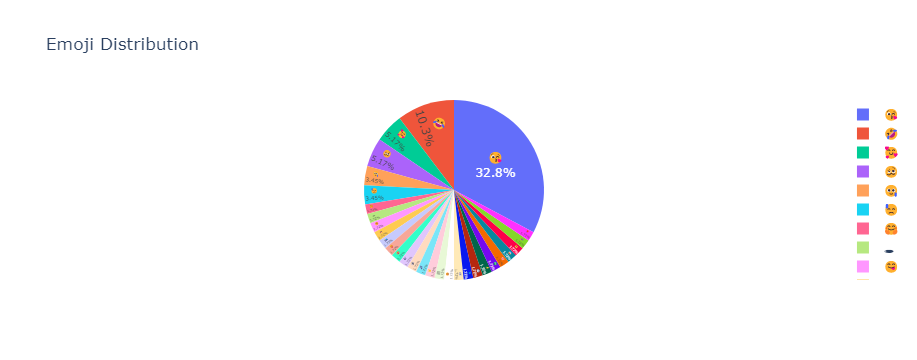

In [115]:
fig = px.pie(emoji_df, values='count', names='emoji', title='Emoji Distribution')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [75]:
text = " ".join(review for review in df.Message)
print ("There are {} words in all the messages.".format(len(text)))

There are 139091 words in all the messages.


In [95]:
stopWords = set(stopwords.words('spanish'))
def remove_stop_words(text):
    return [ token for token in word_tokenize(text) if token.lower() not in stopWords ]

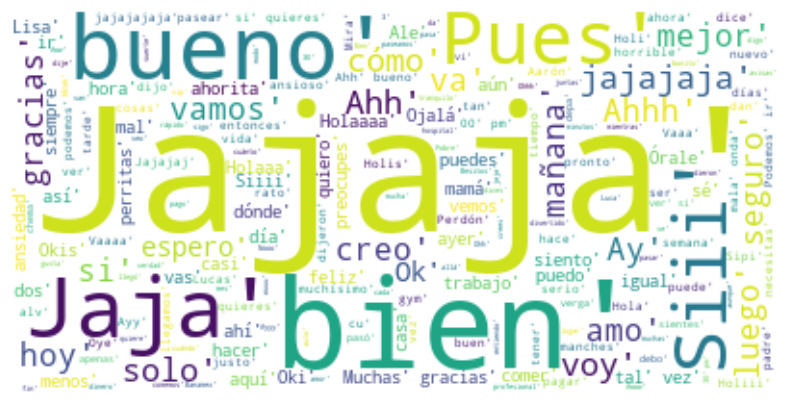

In [116]:
text = ' '.join(map(str,df.Message.apply(lambda x: remove_stop_words(x))))
# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)
# Display the generated image:
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

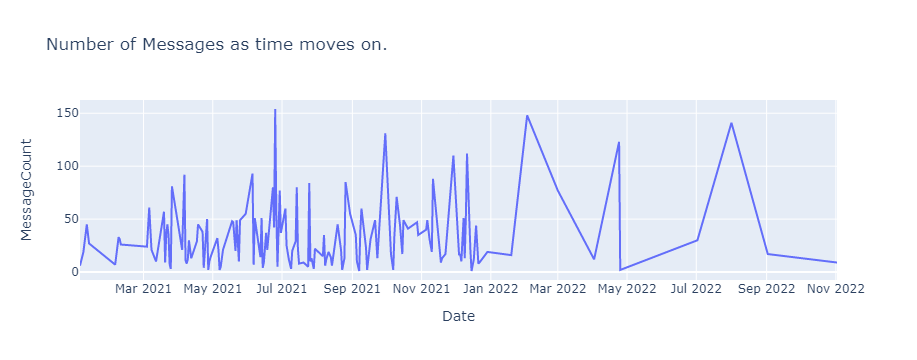

In [118]:
date_df = df['Date'].dt.date.value_counts().sort_index().reset_index()
date_df.columns = ['Date','MessageCount']
fig = px.line(date_df, x="Date", y="MessageCount", title='Number of Messages as time moves on.')
fig.update_xaxes(nticks=20)
fig.show()

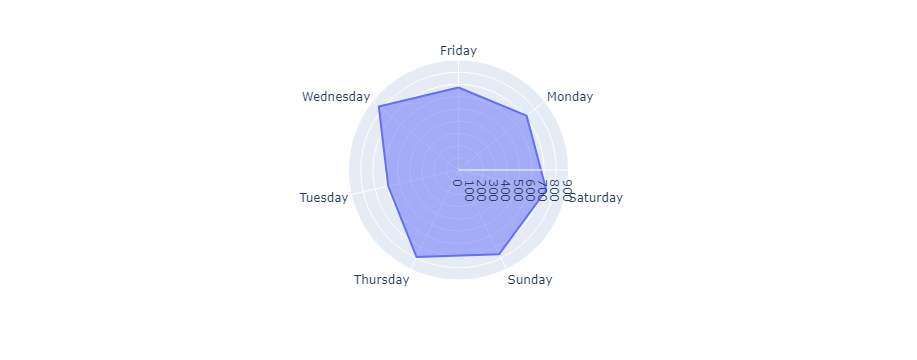

In [127]:
def dayofweek(i):
    l = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    return l[i]

day_df=pd.DataFrame(df["Message"])
day_df['day_of_date'] = df['Date'].dt.weekday
day_df['day_of_date'] = day_df["day_of_date"].apply(dayofweek)
day_df["messagecount"] = 1
day = day_df.groupby("day_of_date").sum()
day.reset_index(inplace=True)

fig = px.line_polar(day, r='messagecount', theta='day_of_date', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0,900]
    )),
  showlegend=False
)
fig.show()

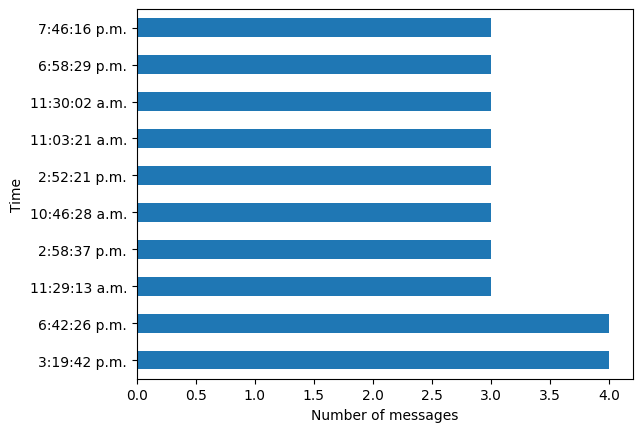

In [130]:
df['Time'].value_counts().head(10).plot.barh() 
plt.xlabel('Number of messages')
plt.ylabel('Time')
plt.show()